In [1]:
import kwant

C:\Users\USER\anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
import matplotlib.pyplot as plt
from math import pi, tanh, sqrt
import scipy.sparse.linalg as sls
import tinyarray

In [3]:
sigma_0 = tinyarray.array([[1,0], [0,1]])
sigma_x = tinyarray.array([[0,1], [1,0]])
sigma_y = tinyarray.array([[0,-1j], [1j,0]])
sigma_z = tinyarray.array([[1,0], [0,-1]])

In [4]:
graphene= kwant.lattice.general([(1,0),(1/2, sqrt(3)/2)], [(0,0),(0,1/sqrt(3))])
a,b = graphene.sublattices
sin_30, cos_30 = (1/2,sqrt(3)/2)

In [5]:
def make_system(r=10, w= 2.0, t = 1, e_z = 0.08, alpha = 0.5, pot = 0.1):
    syst= kwant.Builder()
                    
    def circle(pos):                            # define shape
        x,y= pos
        return x**2 + y**2 < r**2
    
    
    
    
    syst[graphene.shape(circle,(0,0))] = 4* t* sigma_0 + e_z * sigma_z
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] =  -t * sigma_0 + 1j* alpha* sigma_x/ 2 
    
    
    sym0= kwant.TranslationalSymmetry(graphene.vec((-1,0)))        # add first lead
    lead0= kwant.Builder(sym0)
    
    def lead0_shape(pos):                                          # shape of first lead
        x, y = pos
        return (-0.4 * r < y < 0.4 * r)
    
    lead0[graphene.shape(lead0_shape, (0, 0))] = 4* t* sigma_0 + e_z * sigma_z
    lead0[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] =  -t * sigma_0 + 1j* alpha* sigma_x/ 2 
    
    sym1= kwant.TranslationalSymmetry(graphene.vec((0,1)))         # add second lead
    lead1= kwant.Builder(sym1)
    
    def lead1_shape(pos):                                          # shape of second lead
        v = pos[1] * sin_30 - pos[0] * cos_30
        return (-0.4 * r < v < 0.4 * r)
    
    lead1[graphene.shape(lead1_shape, (0, 0))] = 4* t* sigma_0 + e_z * sigma_z
    lead1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] =  -t * sigma_0 + 1j* alpha* sigma_x/ 2 
    
    return syst, [lead0,lead1]

In [6]:
def compute_evs(syst):                                            # energy eigen value of closed system
    sparse_mat= syst.hamiltonian_submatrix(sparse = True)
    evs= sls.eigs(sparse_mat,2)[0]
    print(evs.real)

In [7]:
def plot_conductance(syst, energies):                             # conductance
    t_coef = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        t_coef.append(smatrix.transmission(0,1))
        
    plt.figure()
    plt.plot(energies, t_coef)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.title("conductance of graphene")
    plt.show()
    

In [8]:
def plot_band(flead, momenta):                                    # band structure
    bands= kwant.physics.Bands(flead)
    energies= [bands(k) for k in momenta]
    
    plt.figure()
    plt.plot(momenta, energies)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.title("band structure of graphene lead")
    plt.show()

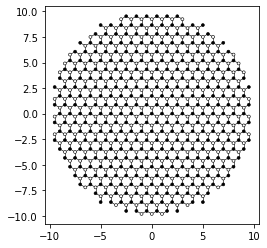

[7.15560308 7.13357113]


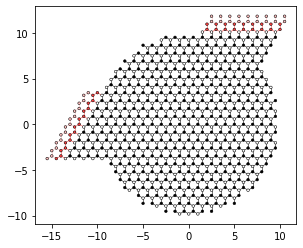

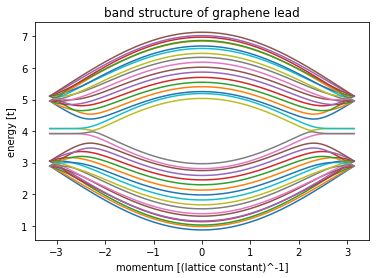

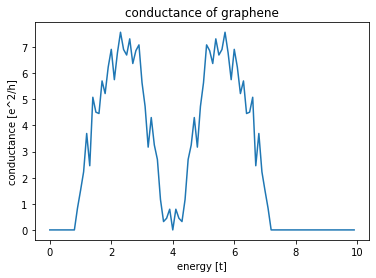

In [9]:
def main():
    
    syst, leads= make_system()
    def family_colors(site):                                      # different color lattice
        return 0 if site.family==a else 1
    
    kwant.plot(syst, site_color = family_colors , site_lw = 0.1, colorbar = False )
    
    compute_evs(syst.finalized())                                 # compute eigen value
    
    for lead in leads:                                            # attach lead
        syst.attach_lead(lead)
        
    kwant.plot(syst, site_color = family_colors , site_lw = 0.1, colorbar = False )
    
    sys= syst.finalized()                                         # finalize the system
    
    momenta = [-pi + 0.02 * pi * i for i in range(101)]           # band structure
    plot_band(sys.leads[0], momenta)
    
    
    energies = [0.1 * en for en in range(100)]
    plot_conductance(sys, energies)
    
    
    
    
    
    
if __name__ == '__main__':
    main()